In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.linalg import eigh
import torch
import time

In [2]:
# Define the transformation function (if not already defined)
def create_genbin_array(gen_bin, bus_to_gen_dict):
    """
    Transforms a 12x24 gen_bin array into a 24x24 template_array based on bus_to_gen_dict.

    Parameters:
    - gen_bin (np.ndarray): A 12x24 NumPy array representing generator statuses.
    - bus_to_gen_dict (dict): A dictionary mapping bus indices to lists of generator indices.

    Returns:
    - template_array (np.ndarray): A 24x24 NumPy array representing bus statuses.
    """
    # Initialize the template array with zeros
    template_array = np.zeros((24, 24))

    # Iterate over each bus and its associated generators
    for bus, gens in bus_to_gen_dict.items():
        # Validate generator indices to prevent IndexError
        valid_gens = [gen for gen in gens if gen < gen_bin.shape[0]]
        if not valid_gens:
            continue  # Skip if no valid generators for this bus

        # Extract the generator rows corresponding to the current bus
        generator_rows = gen_bin[valid_gens]  # Shape: (number_of_generators, 24)

        # Sum the generator rows to get the bus status per hour
        bus_status = generator_rows.sum(axis=0)  # Shape: (24,)

        # Assign the summed status to the corresponding row in the template array
        template_array[bus] = bus_status

    return template_array

def create_load_array(row, bus_numbers=range(1, 25)):
    """
    Transforms a row of bus demands into a 24x24 NumPy array.

    Parameters:
    - row (pd.Series): A row from the DataFrame with bus demands.
    - bus_numbers (iterable): Iterable of bus numbers (1 to 24).

    Returns:
    - load_array (np.ndarray): A 24x24 array with demands per bus per hour.
    """
    # Initialize a 24x24 array with zeros
    load_array = np.zeros((24, 24))

    for bus in bus_numbers:
        if bus in row:
            demands = row[bus]
            if isinstance(demands, (list, np.ndarray)):
                if len(demands) == 24:
                    load_array[bus - 1] = demands
                else:
                    raise ValueError(f"Bus {bus} demands list does not have 24 elements.")
            else:
                raise TypeError(f"Bus {bus} demands are not list or array-like.")
        else:
            # Buses not present remain zeros
            continue

    return load_array
def create_costs(gen_no, cost_type):
    data = generated_gen[gen_no][cost_type]
    bus_start_up = np.zeros(24)
    for bus, gen in bus_to_gen_dict.items():
        bus_start_up[bus] = np.sum([data[gen_no] for gen_no in gen])
    return np.array(bus_start_up)

In [3]:
# ### julia index
# bus_to_gen_dict = {
#     1: [1],
#     2: [2],
#     7: [3],
#     13: [4],
#     15: [5, 6],
#     16: [7],
#     18: [8],
#     21: [9],
#     22: [10],
#     23: [11, 12]
# }
bus_to_gen_dict = {
    0: [0],
    1: [1],
    6: [2],
    12: [3],
    14: [4, 5],
    15: [6],
    17: [7],
    20: [8],
    21: [9],
    22: [10, 11]
}
cost_gen = ["start_up_cost",
                "shut_down_cost",
                "constant_cost_coeff",
                "linear_cost_coeff",
                "min_power",
                "max_power",
                "min_up_time",
                "min_down_time",
                "ramp_up_limit"]

In [4]:
#### create the input matrix for the features
parent_dir = os.getcwd()
parent_dir

'/ztank/scratch/user/u.rd143338/24 bus system/ACES continue'

In [5]:
file_name = os.path.join(parent_dir, "pre NN data","generated_cost.json")
generated_gen = pd.read_json(file_name)

In [6]:
generated_gen.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
generator_no,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
start_up_cost,"[1430.390278216212, 1430.439421788536, 1725.02...","[1430.4588769911434, 1430.3989372722892, 1725....","[1430.369736780654, 1430.3413580501397, 1725.0...","[1430.4074924525805, 1430.413095211171, 1725.0...","[1430.4383303092866, 1430.3571855186963, 1725....","[1430.4098043602617, 1430.3738142432337, 1725....","[1430.4453594884828, 1430.4053084378863, 1725....","[1430.4147343803047, 1430.4107364585125, 1724....","[1430.3811663045956, 1430.3818853650037, 1725....","[1430.4171979005146, 1430.4564527189684, 1724....",...,"[1430.378078530337, 1430.4225853916405, 1724.9...","[1430.3836750229002, 1430.4054145882108, 1724....","[1430.4658511742587, 1430.4216130671628, 1724....","[1430.3965912095339, 1430.3755317815105, 1724....","[1430.4616930711938, 1430.4380989775805, 1725....","[1430.4343561893966, 1430.3885816536917, 1725....","[1430.4304989758166, 1430.4020489267573, 1725....","[1430.4111968843772, 1430.38707831116, 1725.01...","[1430.4829766181197, 1430.3772590264243, 1724....","[1430.4617628088336, 1430.3788783555524, 1725...."
shut_down_cost,"[715.2486424091206, 715.2120684579235, 862.481...","[715.2430975248933, 715.2233336846456, 862.458...","[715.1267754379764, 715.2379728376958, 862.474...","[715.1884555483142, 715.2261629652442, 862.453...","[715.154234021317, 715.1787598913152, 862.4755...","[715.1952244030357, 715.2345363744618, 862.458...","[715.2246817025115, 715.1699837974148, 862.511...","[715.2323544059313, 715.1938438448584, 862.505...","[715.2033048903974, 715.1500476653564, 862.427...","[715.2224203200735, 715.1760315190623, 862.426...",...,"[715.2311767970406, 715.155312274044, 862.5929...","[715.271169161676, 715.1655394177199, 862.4610...","[715.2095294456896, 715.2428409003033, 862.574...","[715.1870569739655, 715.1851573727621, 862.479...","[715.1610157446156, 715.2161646746557, 862.446...","[715.1276655725834, 715.2018613119878, 862.492...","[715.1843113995665, 715.2407512357644, 862.438...","[715.2012780971344, 715.1621169978578, 862.455...","[715.2634961835705, 715.1866683929676, 862.471...","[715.1446200456892, 715.2621274911868, 862.514..."
constant_cost_coeff,"[108.01378963881997, 107.97920739233302, 118.0...","[108.02032517461838, 108.01437070336851, 118.0...","[108.06852828641445, 108.04792108024992, 118.0...","[108.02222541238069, 108.04011045613755, 117.9...","[107.99724259226275, 107.96871077371246, 118.0...","[108.05900738890118, 107.93821757140822, 117.9...","[107.97328948915745, 107.93986971577068, 118.0...","[108.02175961706544, 107.94739819096596, 117.9...","[107.95468281034474, 108.07344394272131, 118.0...","[107.95511694346516, 107.89950726335643, 118.0...",...,"[107.93160708205922, 108.03674653039413, 117.9...","[108.04768950639354, 107.96543273493609, 118.0...","[108.00213304748132, 108.00728375410115, 118.0...","[107.99288195385567, 107.93154653114081, 118.0...","[108.08401233896137, 107.98047087740152, 118.0...","[108.05513261774462, 108.02999479813421, 117.9...","[107.96070226075146, 108.0012843071113, 118.01...","[107.96403301754164, 108.01106768764674, 117.9...","[107.9829

In [7]:
### load the 50,000 uncertain scenarios
file_name = os.path.join(parent_dir, "pre NN data", "generated_load_norm2_load.json")
load_df =  pd.read_json(file_name).T # lines = True, chunksize=1000)
load_df= load_df.apply(
    lambda row: create_load_array(row),
    axis=1
)
load_df.sort_index(inplace=True)

In [8]:
load_df.head()

1    [[66.57515755360195, 64.08105125612477, 59.645...
2    [[94.51095563906414, 8.280524402192128, 47.367...
3    [[81.79820822617985, 92.74477137913073, 62.852...
4    [[56.679610047491295, 103.38990002403611, 102....
5    [[18.694434134289814, 118.6832435034247, 141.0...
dtype: object

In [9]:
uncertainty_range = [25000 * i for i in range(1, 19)]

In [10]:
uncertainty_range     ### not using the 475000, 500000

[25000,
 50000,
 75000,
 100000,
 125000,
 150000,
 175000,
 200000,
 225000,
 250000,
 275000,
 300000,
 325000,
 350000,
 375000,
 400000,
 425000,
 450000]

In [11]:
## final pre NN data has the 
inter_df = pd.concat(
    [
        pd.read_json(
            os.path.join(parent_dir, "pre NN data", f"final_pre_NN_data_norm2_{i}.json")
        )
        for i in uncertainty_range
    ], axis = 1
)
inter_df = inter_df.T
df = pd.DataFrame({
    0: inter_df.apply(lambda row: row.to_dict(), axis=1)
})

In [14]:
df.head()

,0
"(1, 1, 1)","{'gen_on': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
"(2, 1, 1)","{'gen_on': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
"(3, 1, 1)","{'gen_on': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
"(4, 1, 1)","{'gen_on': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
"(5, 1, 1)","{'gen_on': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [15]:
target = df[0].apply(lambda row: row['objective_value']).values

#np.save(os.path.join(parent_dir, "pre NN data", f"target_{load_num}.npy"), target)
np.save(os.path.join(parent_dir, "pre NN data", f"target_norm2.npy"), target)

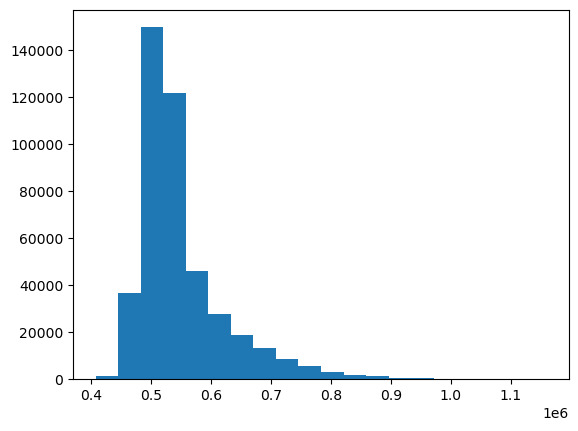

In [16]:
plt.hist(target, bins = 20)
plt.show()

In [17]:
df[['gen_type_no', 'edge_type_no', 'load_type_no']] = df.index.to_series().str.extract(r'\((\d+),\s*(\d+),\s*(\d+)\)').astype(int)
df.sort_values(by='load_type_no', ascending=True, inplace=True)

In [19]:
# Apply the transformation to every row using a lambda function
df['gen_bin_array'] = df.apply(
    lambda row: create_genbin_array(
        np.transpose(row[0]['gen_bin']),  # Extract and transpose 'gen_bin'
        bus_to_gen_dict
    ),
    axis=1
)
df["load_array"] = df['load_type_no'].apply(lambda row: load_df[row])

start_up_cost,
shut_down_cost,
constant_cost_coef,
linear_cost_coef,
Min_electricty_output_limit,
Max_electricty_output_limit,
Ramp_up_limit

In [31]:
np.array(df.iloc[0,0]["susceptance_matrix"])

array([[ 83.95703541, -68.49315068,  -4.43852641,   0.        ,
        -11.02535832,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [-68.49315068,  80.74583073,   0.        ,  -7.37463127,
          0.        ,  -4.87804878,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [ -4.43852641,   0.        ,  24.21110892,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
         -7.86782061,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   

In [32]:
generated_gen.iloc[:,0]

generator_no                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
start_up_cost          [1430.390278216212, 1430.439421788536, 1725.02...
shut_down_cost         [715.2486424091206, 715.2120684579235, 862.481...
constant_cost_coeff    [108.01378963881997, 107.97920739233302, 118.0...
linear_cost_coeff      [13.27681142370591, 13.33915570430695, 20.7118...
min_power              [30.4, 30.4, 75.0, 206.85, 12.0, 54.25, 54.25,...
max_power              [152, 152, 350, 591, 60, 155, 155, 400, 400, 3...
min_up_time                        [8, 8, 8, 12, 4, 8, 8, 1, 1, 0, 8, 8]
min_down_time                      [4, 4, 8, 10, 2, 8, 8, 1, 1, 0, 8, 8]
ramp_up_limit          [152, 152, 350, 240, 60, 155, 155, 280, 280, 3...
ramp_down_limit        [152, 152, 350, 240, 60, 155, 155, 280, 280, 3...
start_ramp_limit       [152, 152, 350, 240, 60, 155, 155, 280, 280, 3...
shut_ramp_limit        [152, 152, 350, 240, 60, 155, 155, 280, 280, 3...
bus_no                     [1, 2, 7, 13, 15, 15, 16

In [33]:
for cost_type in cost_gen:
    df[cost_type] = df["gen_type_no"].apply(lambda row: create_costs(row, cost_type))

In [24]:
high_cost_array = np.zeros(24) ## for 24 buses
for bus, gen in bus_to_gen_dict.items():
    high_cost_array[bus] = 500   ### dont multiply by the cost

In [25]:
feats_array = df.apply(lambda row: np.hstack([row["gen_bin_array"], row["load_array"],
                                row["start_up_cost"].reshape(-1,1), 
                                row["shut_down_cost"].reshape(-1,1), 
                                row["constant_cost_coeff"].reshape(-1,1), 
                                row["linear_cost_coeff"].reshape(-1,1), 
                                row["min_power"].reshape(-1,1), 
                                row["max_power"].reshape(-1,1), 
                                row["min_up_time"].reshape(-1,1), 
                                row["min_down_time"].reshape(-1,1), 
                                row["ramp_up_limit"].reshape(-1,1),
                                high_cost_array.reshape(-1,1)
                               ]), axis = 1).values

In [26]:
feats_array = np.stack(feats_array, axis = 0)

In [27]:
np.save(os.path.join(parent_dir, "pre NN data", "feature_load_array_norm2.npy"), feats_array)

In [34]:
#### Susceptance_matrix
sus_matrix = df[0].apply(lambda row: np.array(row["susceptance_matrix"]))
sus_matrix = np.stack(sus_matrix.values, axis = 0)

np.save(os.path.join(parent_dir, "pre NN data", "sus_matrix_norm2.npy"), sus_matrix)
#np.save(os.path.join(parent_dir, "pre NN data", "sus_matrix_"+str(load_num)+".npy"), sus_matrix)

In [35]:
def repeat_eigenvec_positional_encoding(susceptance_matrix, k = 24):
    ## normalize the laplacian matrix
    D = np.diag(np.diag(susceptance_matrix))    #### this needs to be checked if diagonals are zeros or not
    D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
    D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0  # Handle division by zero
    A = D - susceptance_matrix
    norm_susceptance_matrix = np.eye(susceptance_matrix.shape[0]) - D_inv_sqrt @ A @ D_inv_sqrt

    ### find the eigenvalues and eigenvectors of the susceptance matrix
    eigenvalues, eigenvectors = eigh(norm_susceptance_matrix)
    eigenvalues = np.sort(eigenvalues)
    eigenvectors = eigenvectors[:, eigenvalues.argsort()]
    return eigenvectors


def batch_eigenvec_encoding(susceptance_array):
    """
    Run repeat_eigenvec_positional_encoding on each (24 x 24) matrix in 
    susceptance_array of shape (N, 24, 24).
    
    Returns an array of shape (N, 24, 24) where each slice is the eigenvector matrix.
    """
    N = susceptance_array.shape[0]
    # Prepare output storage
    all_eigenvectors = np.zeros((N, 24, 24), dtype=susceptance_array.dtype)
    
    # Compute eigenvectors for each matrix
    for i in range(N):
        all_eigenvectors[i] = repeat_eigenvec_positional_encoding(susceptance_array[i])
    
    return all_eigenvectors

In [37]:
sus_matrix = np.load(os.path.join(parent_dir, "pre NN data", f"sus_matrix_norm2.npy"))
pos_enc = batch_eigenvec_encoding(sus_matrix)


In [38]:
np.save(os.path.join(parent_dir, "pre NN data", "pos_enc_norm2.npy"), sus_matrix)

In [7]:
torch.cuda.empty_cache() 